In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import nltk
from sklearn.preprocessing import KBinsDiscretizer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

In [24]:
# import sys
# !{sys.executable} -m pip install nltk 
# !{sys.executable} -m pip install scikit-learn --upgrade

In [25]:
df = pd.read_csv('~/Desktop/maven_wave/Baker - Lending Club Data - DR_Demo_Lending_Club.csv',
                 index_col='Id',
                 parse_dates=['earliest_cr_line'],
                 dtype={'is_bad': bool})

print(f'dataset shape = {df.shape}')
print('###########################')
print('dtypes:')
print(df.dtypes.value_counts())

dataset shape = (10000, 27)
###########################
dtypes:
object            12
float64           11
int64              2
datetime64[ns]     1
bool               1
dtype: int64


In [26]:
# Map column to boolean
df['pymnt_plan'] = df.pymnt_plan.map({'y': True, 'n': False})

# Remove 5 records with missing values
bad_ids = [4320, 4329, 4679, 6233, 7593]
df.drop(bad_ids, inplace=True)

In [27]:
# Distribution of response variable
print('is_bad dataset_distribution:')
df.is_bad.value_counts(normalize=True).round(2)

is_bad dataset_distribution:


False    0.87
True     0.13
Name: is_bad, dtype: float64

In [28]:
df.sample()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
8423,False,State of Florida,2,RENT,39600.0,VERIFIED - income,False,"Borrower added on 06/13/11 > Use of Funds:<br/>I plan to use this loan to pay off over $10,000...",debt consolidation,Student debt elimination,331xx,FL,21.21,0.0,2006-12-01,1.0,NaN,NaN,7.0,0.0,4602,53.5,21.0,f,0.0,1,PC3


In [29]:
df.delinq_2yrs.value_counts()

0.0     8910
1.0      822
2.0      186
3.0       50
4.0       14
5.0        6
6.0        3
7.0        2
11.0       1
8.0        1
Name: delinq_2yrs, dtype: int64

In [30]:
df.mths_since_last_delinq.value_counts();
df[(df.mths_since_last_delinq > 0) & (df.mths_since_last_delinq <= 24)].shape

(1149, 27)

In [31]:
# check for missing values
print('Percent missing values:')
(100 * df.isna().sum()[df.isna().sum() > 0] / 10000).round(2).sort_values(ascending=False)

Percent missing values:


mths_since_last_record        91.55
mths_since_last_delinq        63.11
Notes                         32.30
emp_title                      5.89
collections_12_mths_ex_med     0.27
revol_util                     0.21
purpose                        0.04
dtype: float64

In [32]:
df['delinq_2yrs'] = df['delinq_2yrs'].astype(bool)
df.drop(columns=['mths_since_last_delinq'], inplace=True)

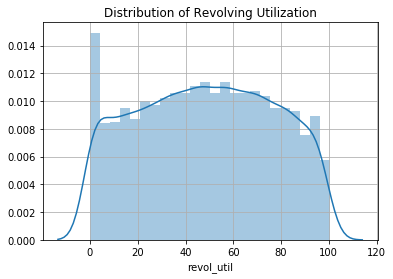

In [33]:
sns.distplot(df.revol_util.dropna());
plt.title('Distribution of Revolving Utilization')
plt.grid();

In [34]:
# Impute missing values
df.loc[df.revol_util.isna(), 'revol_util'] = df.revol_util.dropna().mean()
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9155
Notes                         3230
emp_title                      589
collections_12_mths_ex_med      27
purpose                          4
dtype: int64

In [35]:
# Drop this column
df.drop(columns=['collections_12_mths_ex_med','mths_since_last_record'], inplace=True)

In [36]:
# Discretize this column
# df.mths_since_last_delinq.value_counts(dropna=False).sort_index().plot(grid=True);
# plt.title('Months Since Last Delinquent Value');

In [37]:
# df.groupby('mths_since_last_delinq').is_bad.sum().plot(grid=True, figsize=(8, 6));

In [38]:
# df['delinq_less_4_years'] = False
# df['delinq_over_4_years'] = False
# df.loc[df.mths_since_last_delinq <= 48, 'delinq_less_4_years'] = True
# df.loc[df.mths_since_last_delinq > 48, 'delinq_over_4_years'] = True
# df.drop(columns=['mths_since_last_delinq'], inplace=True)

In [39]:
# est = KBinsDiscretizer()
# res = est.fit_transform(df.mths_since_last_delinq.dropna().values.reshape(-1, 1))
# new_df = pd.DataFrame(index=df.mths_since_last_delinq.dropna().index, 
#                       data=res.toarray()).astype(bool)
# new_df.columns = [f'mths_since_last_delinq_{val}' for val in new_df.columns]
# new_df.sample(5)

In [40]:
# df = pd.merge(df, new_df, how='left', left_index=True, right_index=True).drop(columns=['mths_since_last_delinq'])
# df.loc[df.mths_since_last_delinq_0.isna(), 'mths_since_last_delinq_0':'mths_since_last_delinq_4'] = False
# df.sample(5)

In [41]:
# df.loc[:, 'mths_since_last_delinq_0':'mths_since_last_delinq_4'] = df.loc[:, 'mths_since_last_delinq_0':'mths_since_last_delinq_4'].astype(bool)

In [42]:
df.loc[df.emp_length == 'na', 'emp_length'] = np.NaN
df.emp_length = df.emp_length.astype(float)

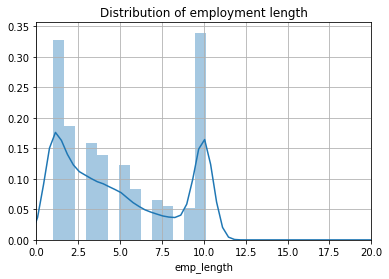

In [46]:
sns.distplot(df.emp_length.dropna());
plt.title('Distribution of employment length')
plt.xlim(0, 20)
plt.grid()

In [48]:
df.loc[df.emp_length.isna(), 'emp_length'] = df.emp_length.dropna().median()

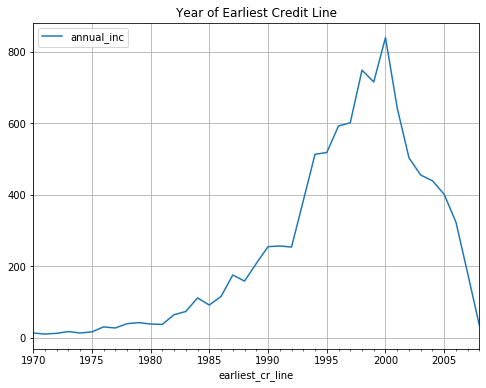

In [49]:
# Some featurization/data cleanup
df.loc[df.earliest_cr_line >= pd.to_datetime('2020-01-01'), 'earliest_cr_line'] = pd.NaT
# df['earliest_cr_cohort_year'] = df.earliest_cr_line.dt.strftime('%Y')
df.set_index('earliest_cr_line')['annual_inc'].resample('Y').size().plot(figsize=(8, 6))
plt.legend();
plt.grid()
plt.title('Year of Earliest Credit Line');

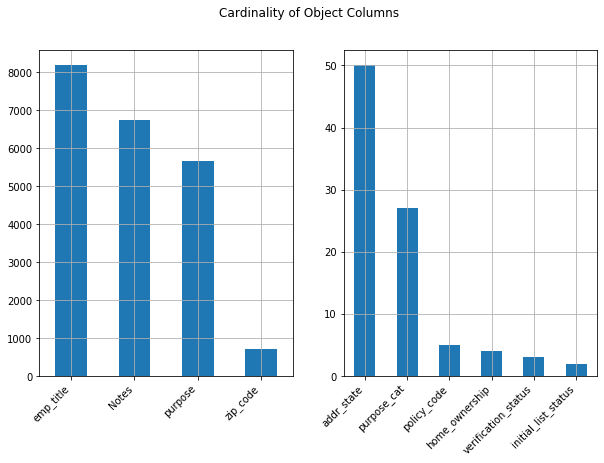

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[:4].plot(kind='bar', grid=True, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[4:].plot(kind='bar', grid=True, ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Cardinality of Object Columns');
# plt.gcf().tight_layout()

In [51]:
def tokenize(text):
        """
        Tokenizes sequences of text and stems the tokens.
        :param text: String to tokenize
        :return: List with stemmed tokens
        """
        tokens = nltk.WhitespaceTokenizer().tokenize(text)
        tokens = list(set(re.sub("[^a-zA-Z\']", "", token) for token in tokens))
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = list(set(re.sub("[^a-zA-Z]", "", token) for token in tokens))
        stems = []
        stemmer = SnowballStemmer("english")
        for token in tokens:
            token = stemmer.stem(token)
            if token != "":
                stems.append(token)
        return stems 

In [52]:
df['is_small_business'] = df.purpose_cat.map(lambda val: 'small business' in val)
df['purpose_cat_clean'] = df.purpose_cat.map(lambda val: val.replace('small business', '').strip())
df.loc[df.purpose_cat_clean == '', 'purpose_cat_clean'] = 'other'
df.drop(columns=['purpose_cat'], inplace=True)
df.purpose_cat_clean.value_counts()

debt consolidation    4556
other                 1512
credit card           1290
home improvement       811
major purchase         551
car                    352
wedding                252
medical                185
moving                 162
educational            112
house                   97
vacation                96
renewable energy        19
Name: purpose_cat_clean, dtype: int64

In [53]:
# Use Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), 
                             stop_words='english', 
                             strip_accents='ascii',
                             min_df=int(df.shape[0]/100),
                             max_df=int(df.shape[0]/10),
                             binary=True)
res = vectorizer.fit_transform(df.purpose.dropna())
print(vectorizer.get_feature_names())
# df.purpose.value_counts().head(50)

['business', 'business loan', 'car', 'card', 'card consolidation', 'card debt', 'cards', 'cc', 'consolidate', 'consolidation loan', 'credit card', 'credit card consolidation', 'credit card debt', 'credit cards', 'debt consolidation loan', 'expenses', 'free', 'help', 'high', 'home', 'home improvement', 'improvement', 'medical', 'moving', 'new', 'pay', 'payoff', 'personal', 'personal loan', 'purchase', 'rate', 'refinance', 'small', 'small business', 'small business loan', 'wedding']


In [54]:
# integer_columns = ['emp_length', 
#                    'delinq_2yrs', 
#                    'inq_last_6mths', 
#                    'mths_since_last_delinq', 
#                    'mths_since_last_record', 
#                    'open_acc', 
#                    'total_acc', 
#                    'mths_since_last_major_derog']
# float_columns = ['debt_to_income', 
#                  'revol_bal', 
#                  'revol_util', 
#                  'annual_inc']
# bool_columns = ['is_bad',
#                 'pymnt_plan']
# obj_columns = ['emp_title', 
#                'home_ownership', 
#                'verification_status', 
#                'Notes', 
#                'purpose_cat_clean',
#                'zip_code', 
#                'addr_state', 
#                'initial_list_status', 
#                'policy_code']
# df.loc[:, integer_columns] = df.loc[:, integer_columns].astype(int)

In [55]:
df.dtypes.sort_values()

is_bad                                   bool
earliest_cr_line               datetime64[ns]
is_small_business                        bool
pymnt_plan                               bool
delinq_2yrs                              bool
mths_since_last_major_derog             int64
revol_bal                               int64
inq_last_6mths                        float64
total_acc                             float64
revol_util                            float64
debt_to_income                        float64
emp_length                            float64
annual_inc                            float64
open_acc                              float64
pub_rec                               float64
policy_code                            object
initial_list_status                    object
verification_status                    object
addr_state                             object
zip_code                               object
purpose                                object
Notes                             

In [56]:
df['zip_code_state'] = df.apply(lambda row: f'{row.zip_code}-{row.addr_state}', axis=1)

In [57]:
df.select_dtypes(include='object').nunique().sort_values(ascending=False)

emp_title              8181
Notes                  6756
purpose                5673
zip_code_state          740
zip_code                720
addr_state               50
purpose_cat_clean        13
policy_code               5
home_ownership            4
verification_status       3
initial_list_status       2
dtype: int64

In [58]:
obj_cols_to_use = df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[3:].index.values.tolist()
print(obj_cols_to_use)

['zip_code_state', 'zip_code', 'addr_state', 'purpose_cat_clean', 'policy_code', 'home_ownership', 'verification_status', 'initial_list_status']


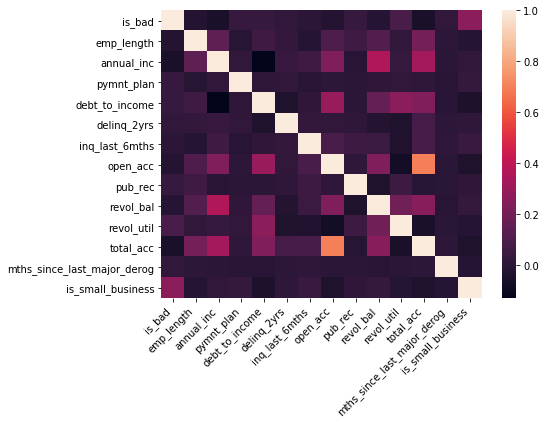

In [59]:
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=[np.number, bool]).corr()
# sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
sns.heatmap(corr, annot=False)
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

<Figure size 576x432 with 0 Axes>

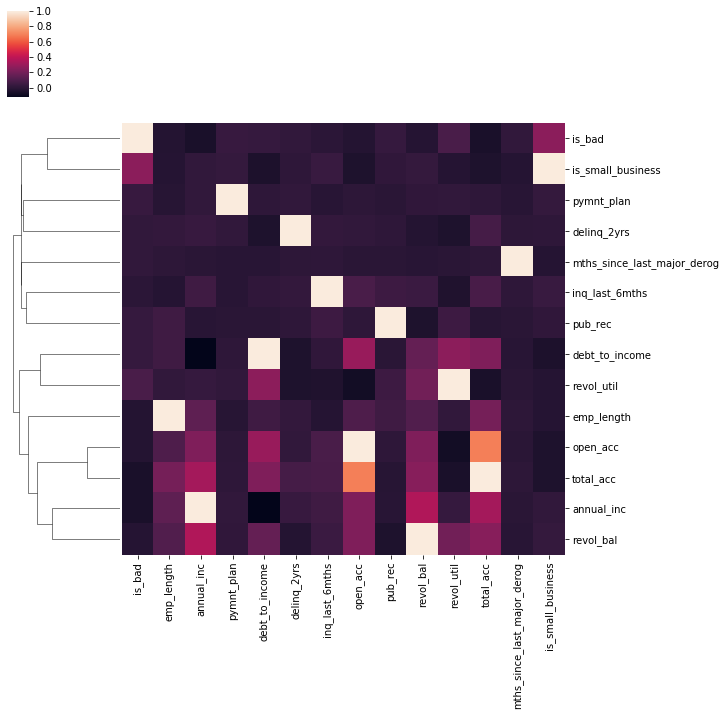

In [60]:
plt.figure(figsize=(8, 6));
sns.clustermap(corr.dropna(), col_cluster=False);
plt.xticks(rotation=45, ha='right');

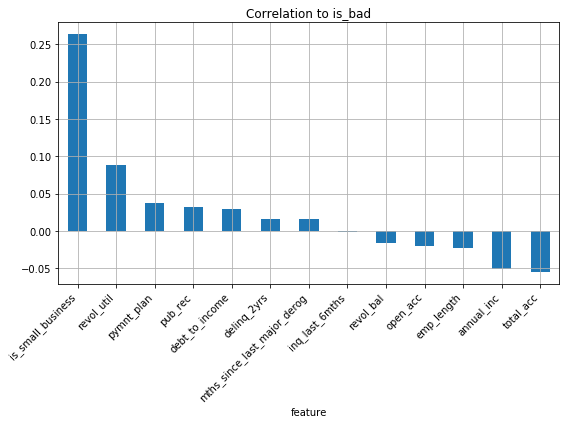

In [61]:
corr_2 = corr.unstack().to_frame('value').reset_index()
corr_2 = corr_2[corr_2.level_0 != corr_2.level_1]

tmp = corr_2[corr_2.level_0 == 'is_bad'].rename(columns={'level_1': 'feature'}).set_index('feature')[
    ['value']].sort_values('value', ascending=False)
tmp.plot(kind='bar', grid=True, legend=None, figsize=(8,6))
plt.title('Correlation to is_bad')
plt.xticks(rotation='45', ha='right')
plt.gcf().tight_layout()

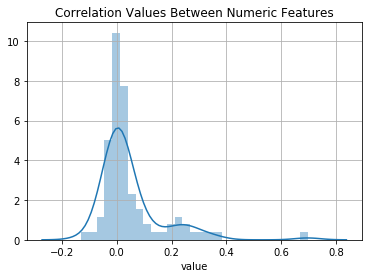

In [62]:
corr_2['features_set'] = corr_2.apply(lambda row: str(sorted([row.level_0, row.level_1])), axis=1)
corr_2 = corr_2.drop_duplicates(subset=['features_set']) \
    .drop(columns=['level_0', 'level_1']) \
    .sort_values('value', ascending=False).dropna()
sns.distplot(corr_2.value)
plt.title('Correlation Values Between Numeric Features')
plt.grid();

In [65]:
# corr_2

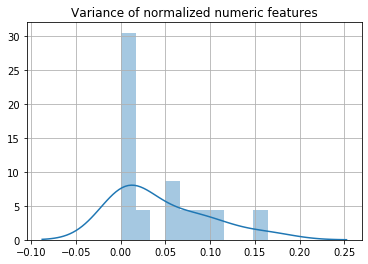

In [66]:
scaler = preprocessing.MinMaxScaler()
df_scale = pd.DataFrame(index=df.select_dtypes(include=[np.number, bool]).index,
                        data=scaler.fit_transform(df.select_dtypes(include=[np.number, bool])),
                        columns=df.select_dtypes(include=[np.number, bool]).columns)
sns.distplot(df_scale.var(), bins=10)
plt.title('Variance of normalized numeric features')
plt.grid()

In [67]:
# Examine feature variance
tmp_2 = (100 * df_scale.var().div(df_scale.var().max())).round(3).sort_values(ascending=False)
print(tmp_2)

mths_since_last_major_derog    100.000
is_bad                          68.587
delinq_2yrs                     58.852
revol_util                      47.752
is_small_business               36.766
debt_to_income                  30.834
total_acc                       10.526
open_acc                         8.629
emp_length                       6.882
pub_rec                          4.265
inq_last_6mths                   2.120
annual_inc                       1.780
revol_bal                        0.270
pymnt_plan                       0.122
dtype: float64


In [68]:
num_cols_to_use = tmp_2.index.values.tolist()
print(num_cols_to_use)

['mths_since_last_major_derog', 'is_bad', 'delinq_2yrs', 'revol_util', 'is_small_business', 'debt_to_income', 'total_acc', 'open_acc', 'emp_length', 'pub_rec', 'inq_last_6mths', 'annual_inc', 'revol_bal', 'pymnt_plan']


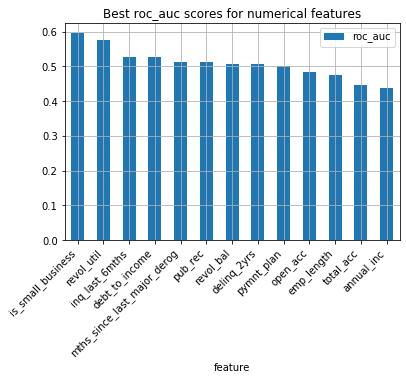

In [69]:
# Compute roc_auc score using numeric features
from sklearn.metrics import roc_auc_score
tmp_df = df[num_cols_to_use].copy()
tmp_df.drop(columns=['is_bad'], inplace=True)
l = []
# tmp_df.apply(lambda col: roc_auc_score(df.is_bad, col))
for col in tmp_df.iteritems():
    new_df = pd.DataFrame(data={'feature': col[1]})
    new_df['label'] = df['is_bad']
    new_df = new_df.dropna()
    val = roc_auc_score(new_df.label, new_df.feature)
    d = {'feature': col[0], 'roc_auc': val}
    l.append(d)
tmp_df_2 = pd.DataFrame(l).sort_values('roc_auc', ascending=False).set_index('feature')
tmp_df_2.plot(kind='bar', grid=True)
plt.xticks(rotation=45, ha='right')
plt.title('Best roc_auc scores for numerical features');

In [70]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

In [74]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

Notes               3230
emp_title            589
earliest_cr_line      35
purpose                4
dtype: int64

In [112]:
cols = sorted(obj_cols_to_use + num_cols_to_use)
cols.remove('zip_code')
print(cols)

['addr_state', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'emp_length', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'is_bad', 'is_small_business', 'mths_since_last_major_derog', 'open_acc', 'policy_code', 'pub_rec', 'purpose_cat_clean', 'pymnt_plan', 'revol_bal', 'revol_util', 'total_acc', 'verification_status', 'zip_code_state']


In [113]:
df.dtypes.value_counts()

object            11
float64            8
bool               4
int64              2
datetime64[ns]     1
dtype: int64

In [114]:
df_1 = df[cols].copy()
df_2 = pd.get_dummies(df_1)
df_2.shape

(9995, 831)

In [117]:
varr = df_2.var().sort_values()
varr = varr[varr >= 0.0025]
varr.shape

(190,)

In [118]:
# from sklearn.impute import SimpleImputer
# df_3 = pd.DataFrame(index=df_2.set_index('is_bad').index, 
#                     columns=df_2.set_index('is_bad').columns,
#                     data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_2.set_index('is_bad')))
# df_3.reset_index(inplace=True)

In [119]:
X = df_2[varr.index.values.tolist()].copy().drop(columns=['is_bad'])
y = df_2[['is_bad']].copy()

In [120]:
# Split into test and train and make sure evenly sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y) 
print(f'y_train value counts = {y_train.is_bad.value_counts(normalize=True).loc[True]:0.2f}')
print(f'y_test value counts = {y_test.is_bad.value_counts(normalize=True).loc[True]:0.2f}')

y_train value counts = 0.13
y_test value counts = 0.12


In [121]:
clf =  LogisticRegression()
clf.fit(X_train, y_train.values.flatten())
preds = y_test.copy()
preds['y_prob_lr'] = clf.predict_proba(X_test)[:, 1]

In [122]:
# Print roc_auc score
print(f'roc auc score with LogisticRegression = {roc_auc_score(preds.is_bad, preds.y_prob_lr)}')

roc auc score with LogisticRegression = 0.5581334341622408


In [123]:
clf = GaussianNB()
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_nb'] = clf.predict_proba(X_test)[:, 1]

In [124]:
# Print roc_auc score
print(f'roc auc score with Naive Bayes = {roc_auc_score(preds.is_bad, preds.y_prob_nb)}')

roc auc score with Naive Bayes = 0.6204876132859672


In [125]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_rf'] = clf.predict_proba(X_test)[:, 1]

In [126]:
print(f'roc auc score with RandomForest = {roc_auc_score(preds.is_bad, preds.y_prob_rf)}')

roc auc score with RandomForest = 0.6659566142590834


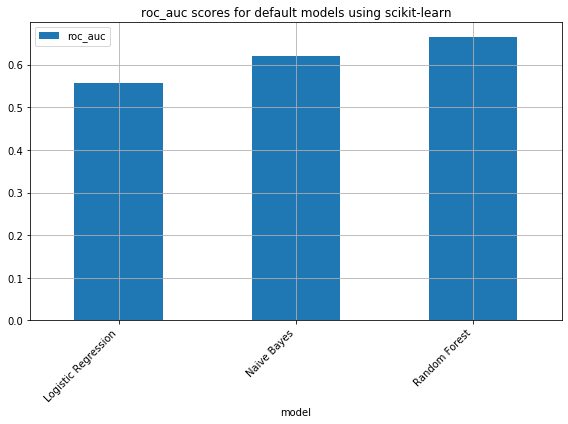

In [127]:
tmp_df = pd.DataFrame([{'model': 'Logistic Regression', 'roc_auc': roc_auc_score(preds.is_bad, preds.y_prob_lr)},
                       {'model': 'Naive Bayes', 'roc_auc': roc_auc_score(preds.is_bad, preds.y_prob_nb)},
                       {'model': 'Random Forest', 'roc_auc': roc_auc_score(preds.is_bad, preds.y_prob_rf)}])
tmp_df.set_index('model').plot(kind='bar', grid=True, figsize=(8,6));
plt.title('roc_auc scores for default models using scikit-learn');
plt.xticks(rotation=45, ha='right');
plt.gcf().tight_layout()

In [128]:
# Use Grid search to find best XGBoost parameters with stochastic column sampling using roc_auc for scoring
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [5, 11], 
    'learning_rate': [0.01, 0.1], 
    'colsample_bytree': [0.5, 0.75, 1.0]
}
b = y_train.is_bad.value_counts()
scale_pos_weight = b.loc[False] / b.loc[True]
xgb_grid_clf = GridSearchCV(XGBClassifier(scale_pos_weight=scale_pos_weight),
                            param_grid,
                            cv=3,
                            verbose=10, 
                            scoring='roc_auc', 
                            n_jobs=-1)
xgb_grid_clf.fit(X_train, y_train.values.flatten())

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.0min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=6.625635808748728,
                                     subsample=None, tree

In [129]:
model = xgb_grid_clf.best_estimator_ 
params = xgb_grid_clf.best_params_ 
scores = xgb_grid_clf.cv_results_
print(f'best params found: {params}')

best params found: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [130]:
y_test = y_test.copy()

In [131]:
# Print classification report
y_test['y_pred'] = model.predict(X_test) 
y_test['y_prob'] = model.predict_proba(X_test)[:, 1]
print('xgboost classification report:')
print('##############################')
print(classification_report(y_test.is_bad, y_test.y_pred))

xgboost classification report:
##############################
              precision    recall  f1-score   support

       False       0.91      0.83      0.87      2187
        True       0.26      0.41      0.32       312

    accuracy                           0.78      2499
   macro avg       0.58      0.62      0.59      2499
weighted avg       0.83      0.78      0.80      2499



In [132]:
# Print roc_auc score
print(f'roc auc score on test data = {roc_auc_score(y_test.is_bad, y_test.y_prob)}')

roc auc score on test data = 0.6981009578746205


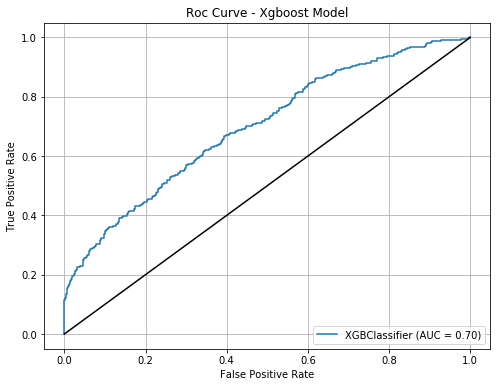

In [148]:
f, ax = plt.subplots(1,1,figsize=(8,6))
plot_roc_curve(model, X_test, y_test.is_bad, ax=ax)
plt.title('Roc Curve - Xgboost Model')
plt.plot([0, 1], [0, 1], c='k')
plt.grid()

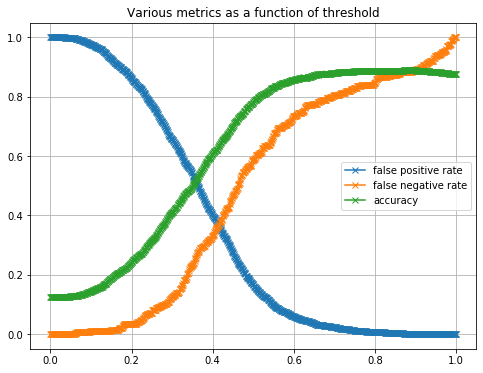

In [161]:
thresholds = np.linspace(0, 1, 1000)
fpr = []
fnr = []
acc = []
for threshold in thresholds:
    y_test['y_pred'] = y_test['y_prob'] >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test.is_bad, y_test.y_pred).ravel()
    fpr.append(fp / (fp + tn))
    fnr.append(fn / (fn + tp))
    acc.append((tn + tp) / (tn + fp + fn + tp))
f, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(thresholds, fpr, label='false positive rate', marker='x');
plt.plot(thresholds, fnr, label='false negative rate', marker='x');
plt.plot(thresholds, acc, label='accuracy', marker='x');
plt.title('Various metrics as a function of threshold')
plt.legend();
plt.grid();

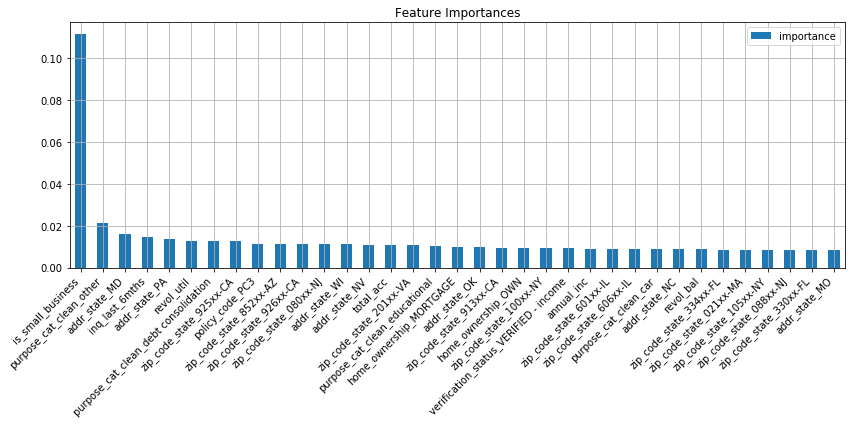

In [134]:
# Plot feature importances
tmp = pd.DataFrame(index=X_test.columns, 
                   data={'importance': model.feature_importances_}).sort_values('importance', ascending=False) 
# tmp[tmp.importance > 0].plot(kind='bar', grid=True, figsize=(12,10)) 
tmp.head(35).plot(kind='bar', grid=True, figsize=(12,6)) 
plt.xticks(rotation=45, ha='right');
plt.title('Feature Importances'); plt.gcf().tight_layout();

In [135]:
# tmp.loc[num_cols_to_use].head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
# plt.xticks(rotation=45, ha='right');
# plt.title('Feature Importances'); 
# plt.gcf().tight_layout();

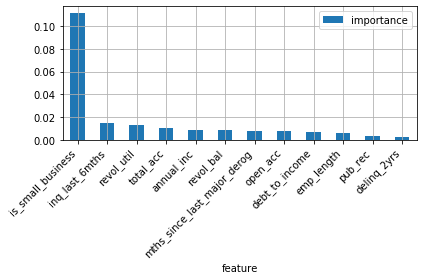

In [136]:
tmp_2 = tmp.reset_index().rename(columns={'index': 'feature'})
tmp_3 = tmp_2[tmp_2.feature.isin(num_cols_to_use)].set_index('feature')
tmp_3.plot(kind='bar', grid=True);
plt.xticks(rotation=45, ha='right');
plt.gcf().tight_layout()

In [137]:
cat = tmp.iloc[0].name
res = df_2[[cat, 'is_bad']]
res.corr()

,is_small_business,is_bad
is_small_business,1.0000,0.2633
is_bad,0.2633,1.0000


In [138]:
cat = tmp.iloc[1].name
res = df_2[[cat, 'is_bad']]
res.corr()

,purpose_cat_clean_other,is_bad
purpose_cat_clean_other,1.00000,0.06244
is_bad,0.06244,1.00000


In [139]:
cat = tmp.iloc[2].name
res = df_2[[cat, 'is_bad']]
res.corr()

,addr_state_MD,is_bad
addr_state_MD,1.000000,-0.006364
is_bad,-0.006364,1.000000


In [143]:
print('correlation scores:')
print('###################')
for i in range(tmp.shape[0]):
    cat = tmp.iloc[i].name
    res = df_2[[cat, 'is_bad']]
    print(f'{cat}:{res.corr().iloc[0].is_bad:0.3f}')

correlation scores:
###################
is_small_business:0.263
purpose_cat_clean_other:0.062
addr_state_MD:-0.006
inq_last_6mths:-0.001
addr_state_PA:-0.022
revol_util:0.088
purpose_cat_clean_debt consolidation:0.020
zip_code_state_925xx-CA:0.024
policy_code_PC3:-0.024
zip_code_state_852xx-AZ:0.010
zip_code_state_926xx-CA:0.024
zip_code_state_080xx-NJ:0.013
addr_state_WI:-0.011
addr_state_NV:0.034
total_acc:-0.055
zip_code_state_201xx-VA:-0.015
purpose_cat_clean_educational:-0.010
home_ownership_MORTGAGE:-0.032
addr_state_OK:0.001
zip_code_state_913xx-CA:0.018
home_ownership_OWN:0.012
zip_code_state_100xx-NY:-0.015
verification_status_VERIFIED - income:0.043
annual_inc:-0.051
zip_code_state_601xx-IL:0.006
zip_code_state_606xx-IL:-0.013
purpose_cat_clean_car:-0.022
addr_state_NC:0.017
revol_bal:-0.016
zip_code_state_334xx-FL:0.018
zip_code_state_021xx-MA:-0.018
zip_code_state_105xx-NY:-0.006
zip_code_state_088xx-NJ:-0.015
zip_code_state_330xx-FL:0.026
addr_state_MO:0.010
zip_code_state

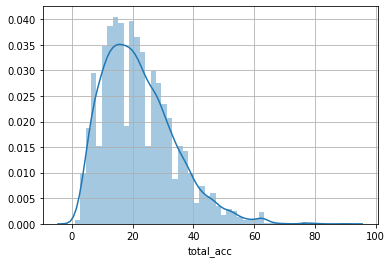

In [141]:
sns.distplot(df_2.total_acc.dropna());
plt.grid();

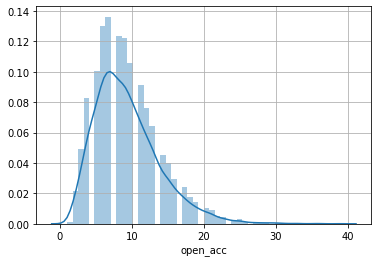

In [142]:
sns.distplot(df_2.open_acc.dropna());
plt.grid();